# Multilayer Perceptron (MLP) - An example to compare the linear model with the MLP

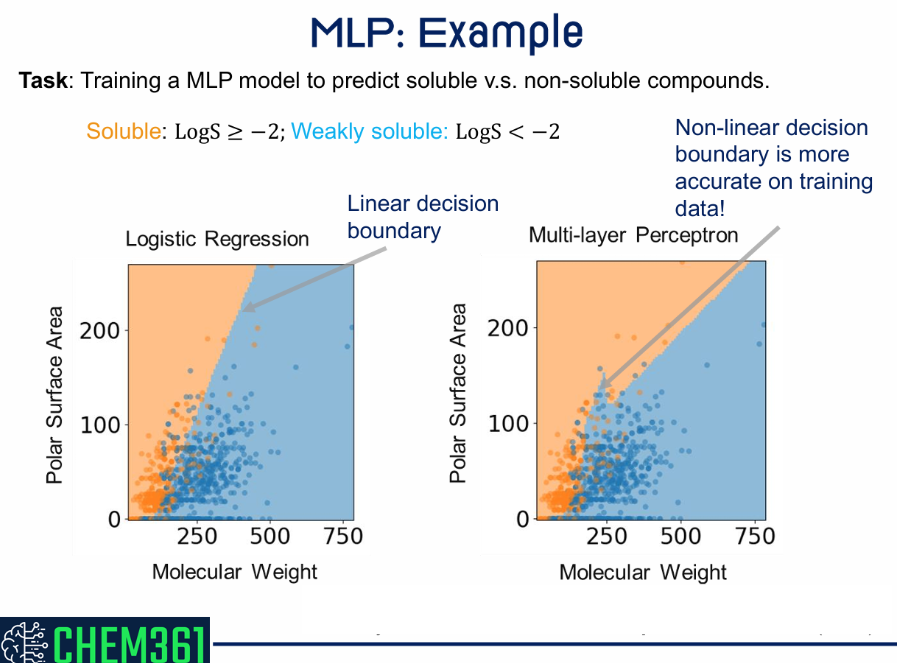

In [ ]:
!pip install pandas numpy matplotlib torch wget seaborn scikit-learn

In [2]:
import numpy as np
import pandas as pd

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

cmap = plt.get_cmap('tab10')
colors = [cmap(i) for i in range(cmap.N)]

mpl.rcParams["font.size"] = 24
mpl.rcParams["lines.linewidth"] = 2

## Load Dataset

In [3]:
!python -m wget https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv \
    --output delaney-processed.csv


Saved under delaney-processed.csv


In [4]:
DELANEY_FILE = "delaney-processed.csv"
TASK_COL = 'measured log solubility in mols per litre'
df = pd.read_csv(DELANEY_FILE)
print(f"Number of molecules in the dataset: {df.shape[0]}")

Number of molecules in the dataset: 1128


In [5]:
X = df[[
        "Molecular Weight",
        "Polar Surface Area"]].values
Y = (df[TASK_COL].values.reshape(-1, 1) >= -2).astype(int)
print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)

Shape of X: (1128, 2)
Shape of Y: (1128, 1)


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cpu


## Linear Model

In [7]:
class LinearRegresion(torch.nn.Module):
    def __init__(self, indim):
        super(LinearRegresion, self).__init__()
        self.norm = nn.BatchNorm1d(indim)
        self.linear = torch.nn.Linear(indim, 1)
    def forward(self, x):
        x = self.norm(x)
        x = self.linear(x)
        return x

## MLP Model

MLP containing 2 hidden layers and with 2 input features (Molecular Weight", "Polar Surface Area).

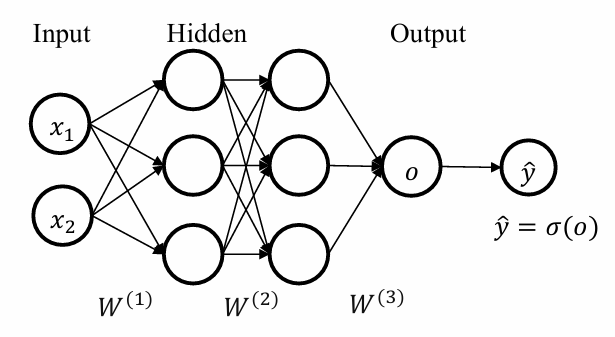

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLPRegresion(torch.nn.Module):
    def __init__(self, in_dim):
        super(MLPRegresion, self).__init__()
        self.model = nn.Sequential(*[
            # Normalizes input features.
            nn.BatchNorm1d(in_dim),

            # input -> hidden layer 1
            # 10 neurons in hidden layer 1
            nn.Linear(in_dim, 10),
            nn.ReLU(),

            # hidden layer 1 -> hidden layer 2
            # 5 neurons in hidden layer 2
            nn.Linear(10, 5),
            nn.ReLU(),

            # hidden layer 2 -> output
            nn.Linear(5, 1),
        ])

    def forward( self, x):
        for layer in self.model:
            x = layer(x)
        return x

## Training Utils

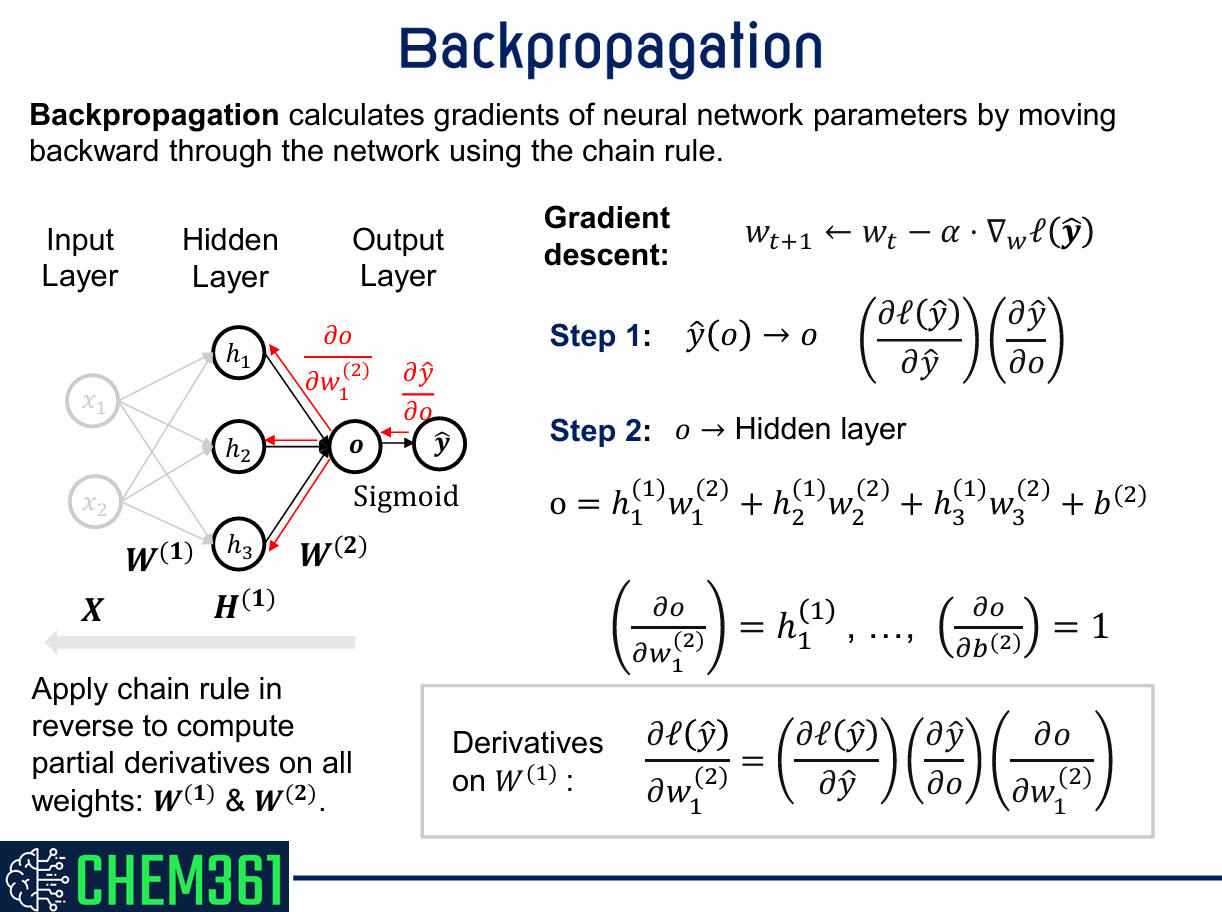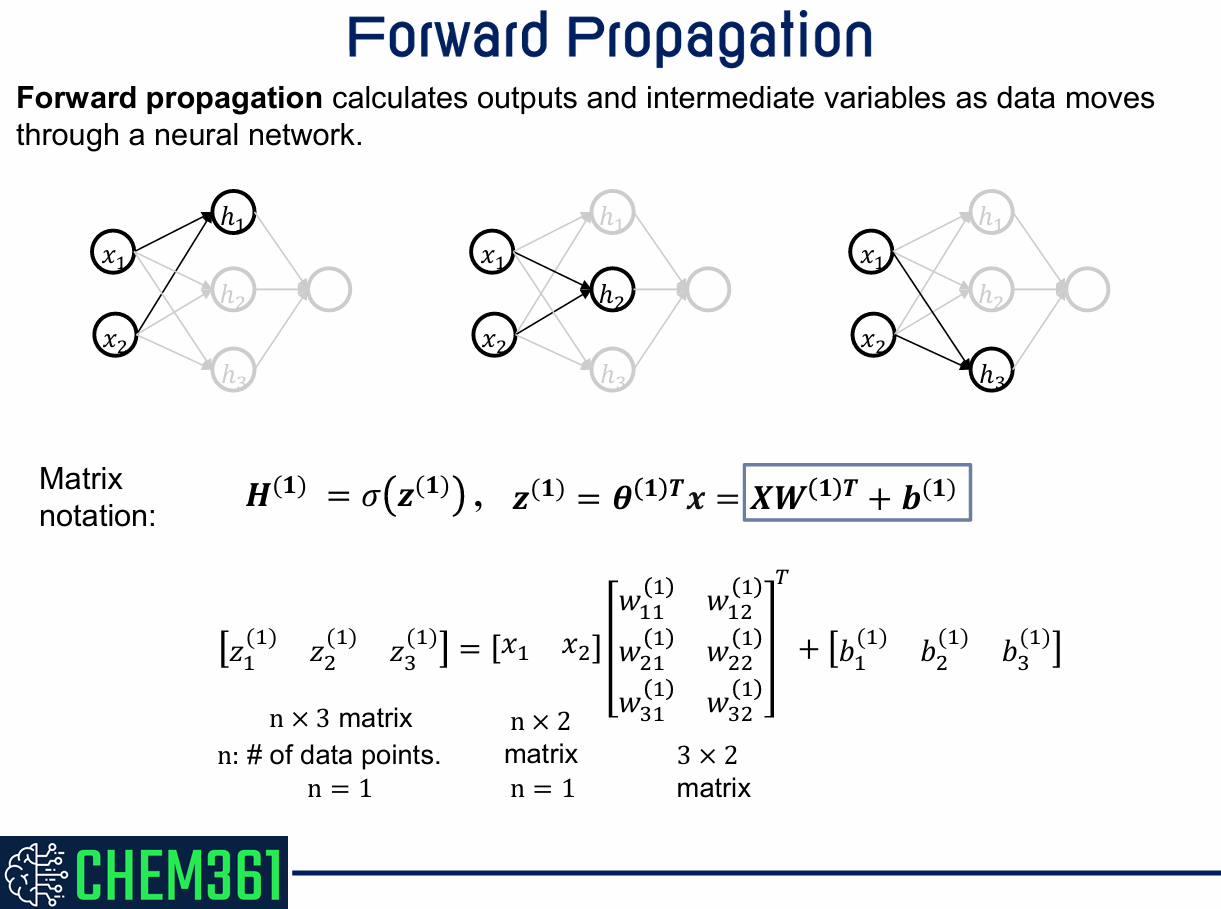

In [9]:
def train_one_epcoh(model, criterion, optimizer, dataloader):
    losses = []
    model.train()
    for x, y_true in dataloader:
        if device == "cuda":
            x, y_true = x.to(device), y_true.to(device)
        x, y_true = x.float(), y_true.float()
        optimizer.zero_grad() #initalize the gradients to be zero
        output = model(x) # forward progagation in Pytorch
        y_pred = torch.sigmoid(output) # sigmoid transformation to obtain y^hat
        # cross entropy loss
        loss = criterion(y_pred, y_true.reshape(y_pred.shape))
        loss.backward() # backprogagation
        optimizer.step() # update gradient for 1 step
        losses.append(loss.cpu().detach().item()) # record the loss .detach()
    return losses

# no backprogagation, no optimization
def val_one_epcoh(model, criterion, dataloader):
    losses = []
    model.eval()
    with torch.no_grad():
        for x, y_true in dataloader:
            if device == "cuda":
                x, y_true = x.to(device), y_true.to(device)
            x, y_true = x.float(), y_true.float()
            output = model(x)
            y_pred = torch.sigmoid(output)
            loss = criterion(y_pred, y_true.reshape(y_pred.shape))
            losses.append(loss.cpu().detach().item())
    return losses

## Prepare Dataset

In [10]:
from sklearn.model_selection import train_test_split

# training/validation dataset
test_size = int(len(X)*0.1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, shuffle=True)

# create dataloaders
# X_train, X_test, y_train, y_test = map(torch.tensor, (X_train, X_test, y_train, y_test))
X_train, X_test, y_train, y_test = map(
    lambda x: torch.tensor(x, dtype=torch.float32), (X_train, X_test, y_train, y_test)
)

batch_size = 128
train_data = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           shuffle=True, drop_last=False)
test_data = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                          shuffle=False, drop_last=False)

In [11]:
# grid data for visualization
x_min, x_max = X_train[:, 0].min(), X_train[:, 0].max()
y_min, y_max = X_train[:, 1].min(), X_train[:, 1].max()

xx = np.linspace(x_min, x_max, 100)
yy = np.linspace(y_min, y_max, 100)

xx, yy = np.meshgrid(xx, yy)
grids = np.hstack([xx.ravel().reshape(-1, 1), yy.ravel().reshape(-1, 1)])

grid_data = torch.utils.data.TensorDataset(
    torch.tensor(grids).float()
)
grid_loader = torch.utils.data.DataLoader(grid_data, batch_size=batch_size,
                                          shuffle=False, drop_last=False)

## Train Logistic Model

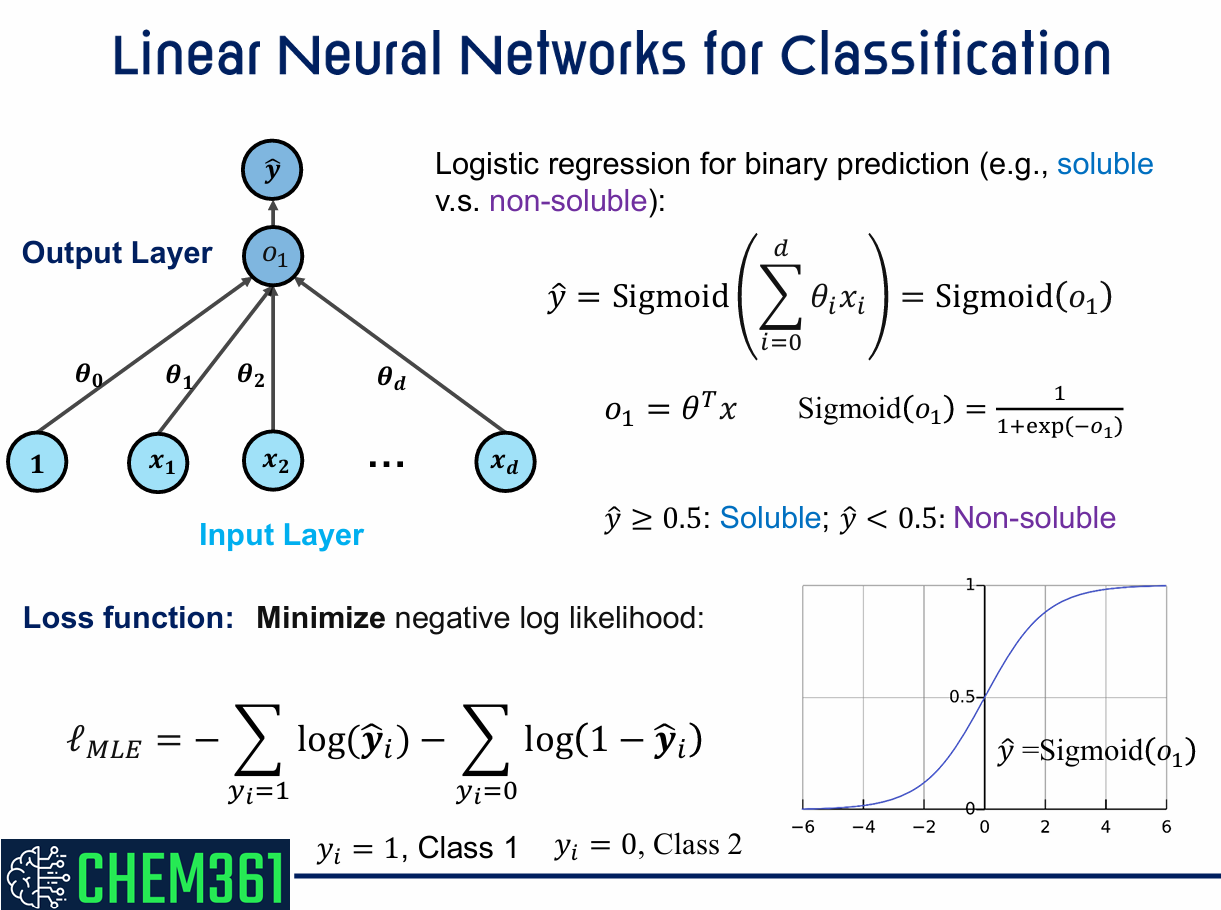

In [12]:
model = LinearRegresion(2)
model = model.to(device)
model = model.float()
criterion = torch.nn.BCELoss() # Selection of the binary cross entrpy loss
optimizer = torch.optim.SGD(model.parameters(), lr=0.01) #batch gradient descent
n_epochs = 500

train_loss = []
val_loss = []

for epoch in range(n_epochs):
    losses = train_one_epcoh(model, criterion, optimizer, train_loader) # training
    train_loss.append(np.mean(losses)) # average losses of the batches within the epoch
    losses = val_one_epcoh(model, criterion, test_loader) # testing
    val_loss.append(np.mean(losses))

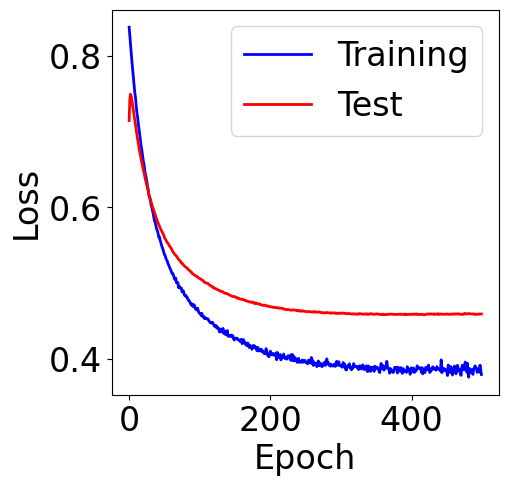

In [13]:
f, ax = plt.subplots(1, 1, figsize=(5,5))

ax.plot(train_loss, c="blue", label="Training")
ax.plot(val_loss, c="red", label="Test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [14]:
model.eval()
truth = []
preds = []
with torch.no_grad():
    for x, y_true in test_loader:
        if device == "cuda":
            x, y_true = x.to(device), y_true.to(device)
        x, y_true = x.float(), y_true.float()

        output = model(x)
        y_pred = torch.sigmoid(output).reshape(-1)
        preds.extend([y_pred[i].item() for i in range(len(y_pred))])

        y_true = y_true.reshape(y_pred.shape)
        truth.extend([y_true[i].item() for i in range(len(y_true))])

confusion_matrix(np.array(truth), np.array(preds)>0.5)

array([[60,  9],
       [11, 32]])

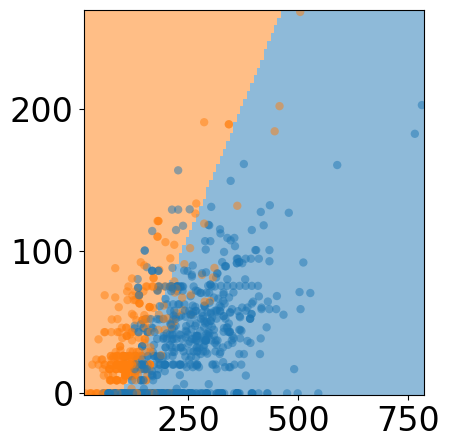

In [15]:
predictions = []
model.eval()
with torch.no_grad():
    for x, in grid_loader:
        if device == "cuda":
            x = x.to(device)
        x = x.float()
        output = model(x)
        y_pred = torch.sigmoid(output).reshape(-1)
        predictions.extend([y_pred[i].item() for i in range(len(y_pred))])


# plot space separation
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

custom_cmap = ListedColormap([cmap(0), cmap(1)])
mesh_pred = np.array(predictions).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_pred>=0.5,
              cmap=custom_cmap, alpha=0.5)
plt.scatter(X_train[:, 0], X_train[:, -1],
            c=y_train, cmap=custom_cmap,
            edgecolors='none', alpha=0.5)
fig.tight_layout()

## Train MLP Model

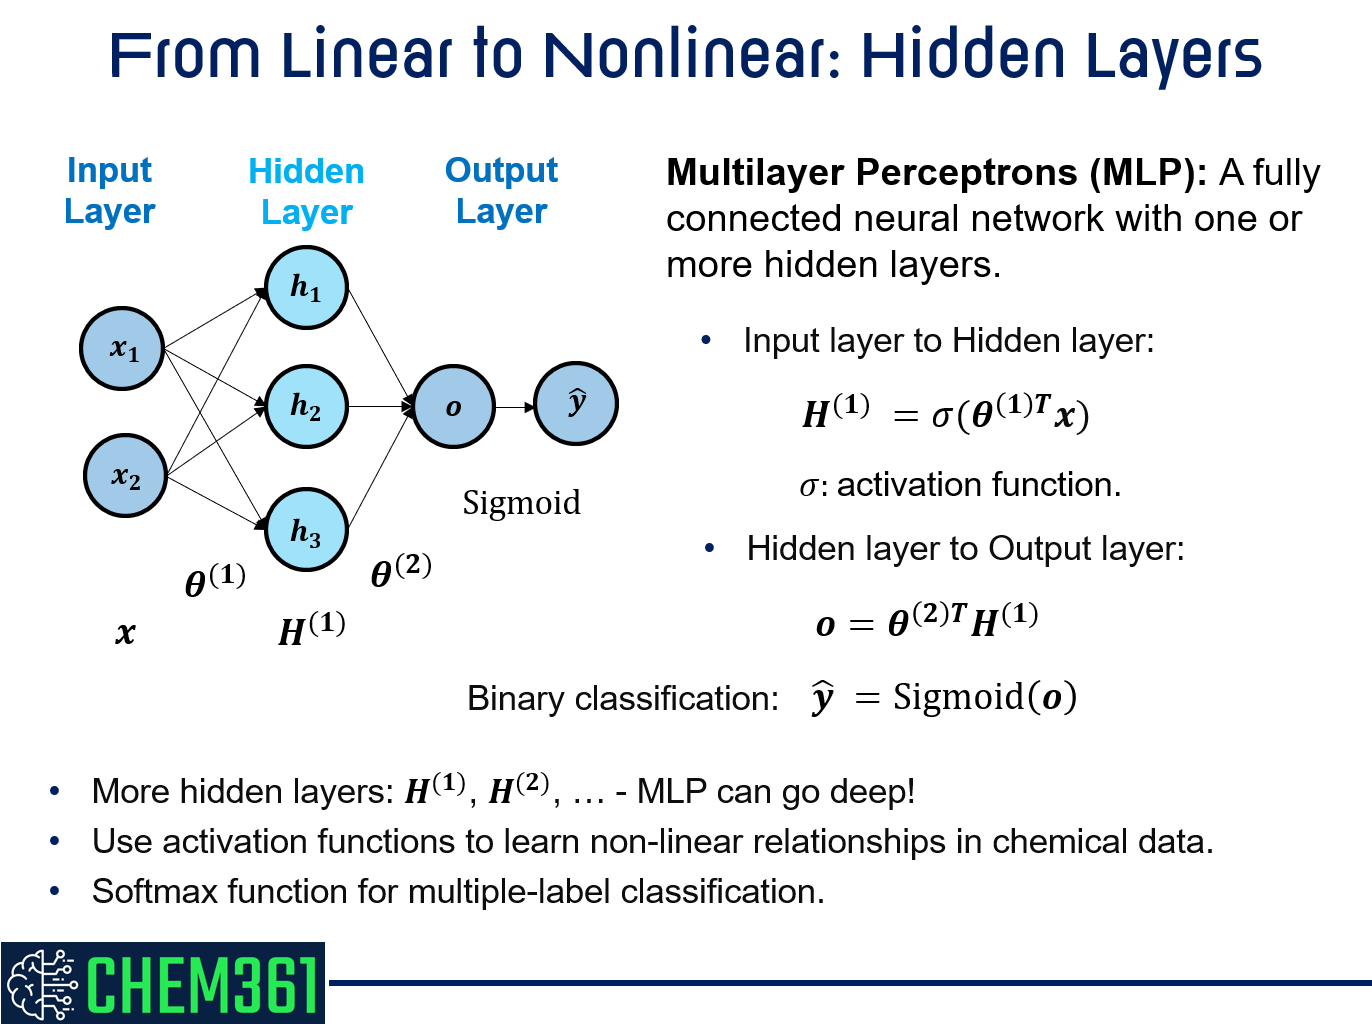

In [16]:
model = MLPRegresion(2) # 2 input features
model = model.to(device)
model = model.float()
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
n_epochs = 1000

train_loss = []
val_loss = []

for epoch in range(n_epochs):
    losses = train_one_epcoh(model, criterion, optimizer, train_loader)
    train_loss.append(np.mean(losses))
    losses = val_one_epcoh(model, criterion, test_loader)
    val_loss.append(np.mean(losses))

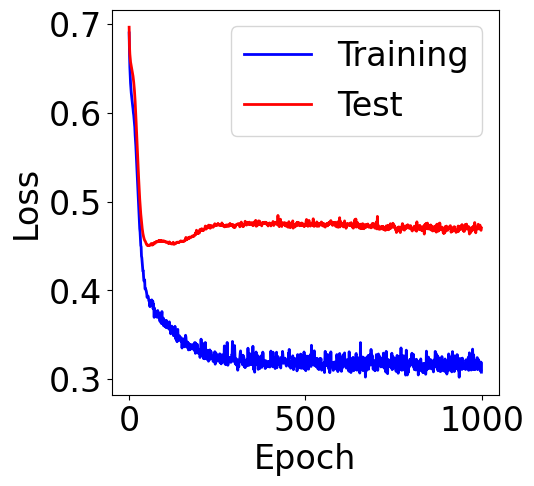

In [17]:
f, ax = plt.subplots(1, 1, figsize=(5,5))

ax.plot(train_loss, c="blue", label="Training")
ax.plot(val_loss, c="red", label="Test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [18]:
model.eval()
truth = []
preds = []
with torch.no_grad():
    for x, y_true in test_loader:
        if device == "cuda":
            x, y_true = x.to(device), y_true.to(device)
        x, y_true = x.float(), y_true.float()

        output = model(x)
        y_pred = torch.sigmoid(output).reshape(-1)
        preds.extend([y_pred[i].item() for i in range(len(y_pred))])

        y_true = y_true.reshape(y_pred.shape)
        truth.extend([y_true[i].item() for i in range(len(y_true))])

confusion_matrix(np.array(truth), np.array(preds)>0.5)

array([[63,  6],
       [12, 31]])

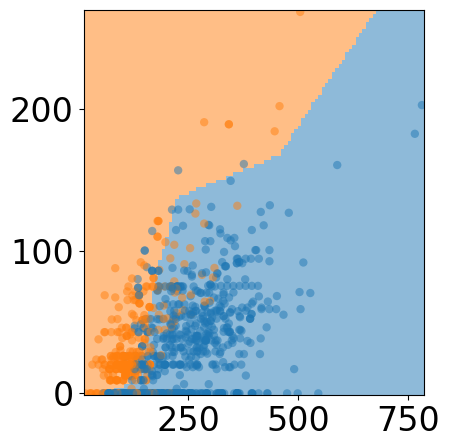

In [19]:
predictions = []
model.eval()
with torch.no_grad():
    for x, in grid_loader:
        if device == "cuda":
            x = x.to(device)
        x = x.float()
        output = model(x)
        y_pred = torch.sigmoid(output).reshape(-1)
        predictions.extend([y_pred[i].item() for i in range(len(y_pred))])


# plot space separation
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

custom_cmap = ListedColormap([cmap(0), cmap(1)])
mesh_pred = np.array(predictions).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_pred>=0.5,
              cmap=custom_cmap, alpha=0.5)
plt.scatter(X_train[:, 0], X_train[:, -1],
            c=y_train, cmap=custom_cmap,
            edgecolors='none', alpha=0.5)
fig.tight_layout()